## Importação e Leitura dos Dados


In [53]:
import pandas as pd

# Carregar os dados
df = pd.read_csv("datasets/build/basquet_com_ME.csv")
df = df.dropna()
df.head()


,Date,Close,Open,Price_diff,fng_value,RSI,MA_14,ME_Impact,ME
13,2020-09-11,5262.487083,5245.468464,17.018619,41.0,34.701876,5456.804663,0,0
14,2020-09-12,5285.290680,5266.942148,18.348532,41.0,35.658919,5418.647137,0,0
15,2020-09-13,5222.762695,5290.458913,-67.696218,38.0,30.549799,5368.384965,0,0
16,2020-09-14,5403.185851,5225.275051,177.910800,39.0,37.054926,5332.031164,0,0
17,2020-09-15,5458.967116,5401.624649,57.342467,47.0,33.864796,5288.831472,0,0


## Seleção de Features e Divisão do Dataset

In [54]:
from sklearn.model_selection import train_test_split

# Selecionar features e target
X = df[["Open", "fng_value", "Price_diff", "RSI", "MA_14","ME","ME_Impact"]]

y = df["Close"]

# Split sem shuffle por ser série temporal
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False, test_size=0.2)


# Pré-Tratamento


In [55]:
from sklearn.preprocessing import StandardScaler
import pandas as pd

# separar coluna ME antes do scaling
ME_train = X_train[['ME']]
ME_test = X_test[['ME']]

# Features numéricas contínuas (todas menos a ME)
numeric_features = X_train.drop(columns=['ME']).columns

# Escalar apenas as features numéricas contínuas
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train[numeric_features])
X_test_scaled = scaler.transform(X_test[numeric_features])

# Converter novamente para DataFrame
X_train_scaled = pd.DataFrame(X_train_scaled, columns=numeric_features, index=X_train.index)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=numeric_features, index=X_test.index)

# Adicionar novamente coluna ME
X_train_scaled['ME'] = ME_train
X_test_scaled['ME'] = ME_test

## Treinamento do Modelo AdaBoost

In [56]:
from sklearn.ensemble import AdaBoostRegressor

ada_model = AdaBoostRegressor(n_estimators=500, learning_rate=0.05, random_state=42)
ada_model.fit(X_train, y_train)


AdaBoostRegressor(learning_rate=0.05, n_estimators=500, random_state=42)

MSE: 64963827.63679636


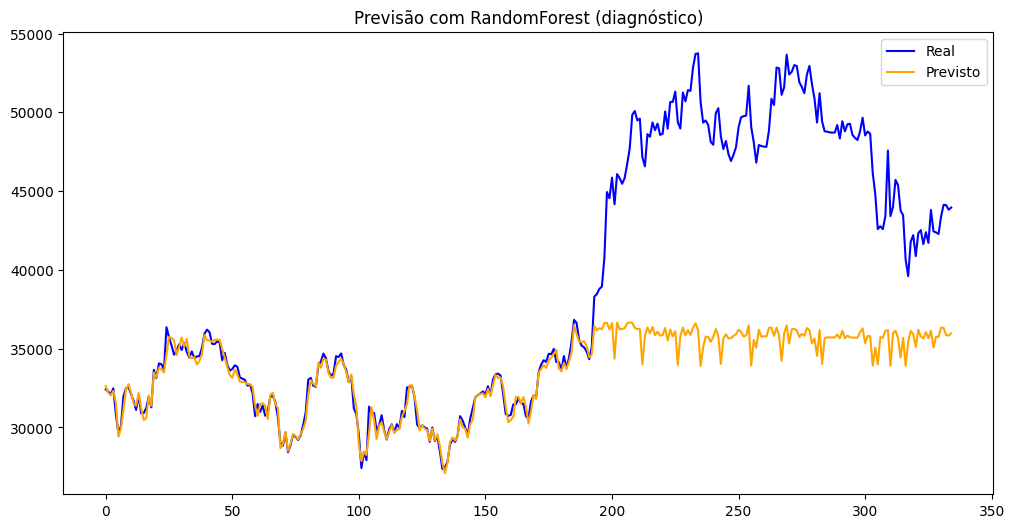

In [57]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train_scaled, y_train)

preds = model.predict(X_test_scaled)

# Avaliação rápida
mse = mean_squared_error(y_test, preds)
print("MSE:", mse)

# Plot para visualizar
plt.figure(figsize=(12, 6))
plt.plot(y_test.values, label='Real', color='blue')
plt.plot(preds, label='Previsto', color='orange')
plt.legend()
plt.title('Previsão com RandomForest (diagnóstico)')
plt.show()

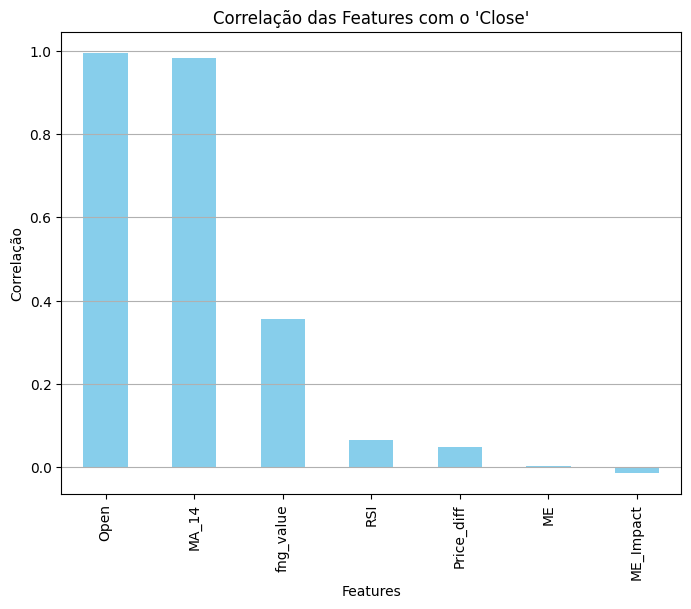

Close         1.000000
Open          0.995927
MA_14         0.982852
fng_value     0.355082
RSI           0.063543
Price_diff    0.048904
ME            0.002792
ME_Impact    -0.014446
Name: Close, dtype: float64


In [58]:
import matplotlib.pyplot as plt

# Adicionar novamente a coluna 'Close' ao X_train para correlação
X_corr = X_train_scaled.copy()
X_corr['Close'] = y_train

# Calcular a correlação com 'Close'
correlation_with_close = X_corr.corr()['Close'].sort_values(ascending=False)

# Plotar gráfico
plt.figure(figsize=(8, 6))
correlation_with_close.drop('Close').plot(kind='bar', color='skyblue')
plt.title("Correlação das Features com o 'Close'")
plt.ylabel("Correlação")
plt.xlabel("Features")
plt.grid(axis='y')
plt.show()

# Exibir correlações numericamente
print(correlation_with_close)

## Avaliação do Modelo

In [59]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

y_pred = ada_model.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)

print("RMSE:", rmse)
print("MAE:", mae)



RMSE: 8780.871438594853
MAE: 5967.18082874689


## Visualização dos Resultados

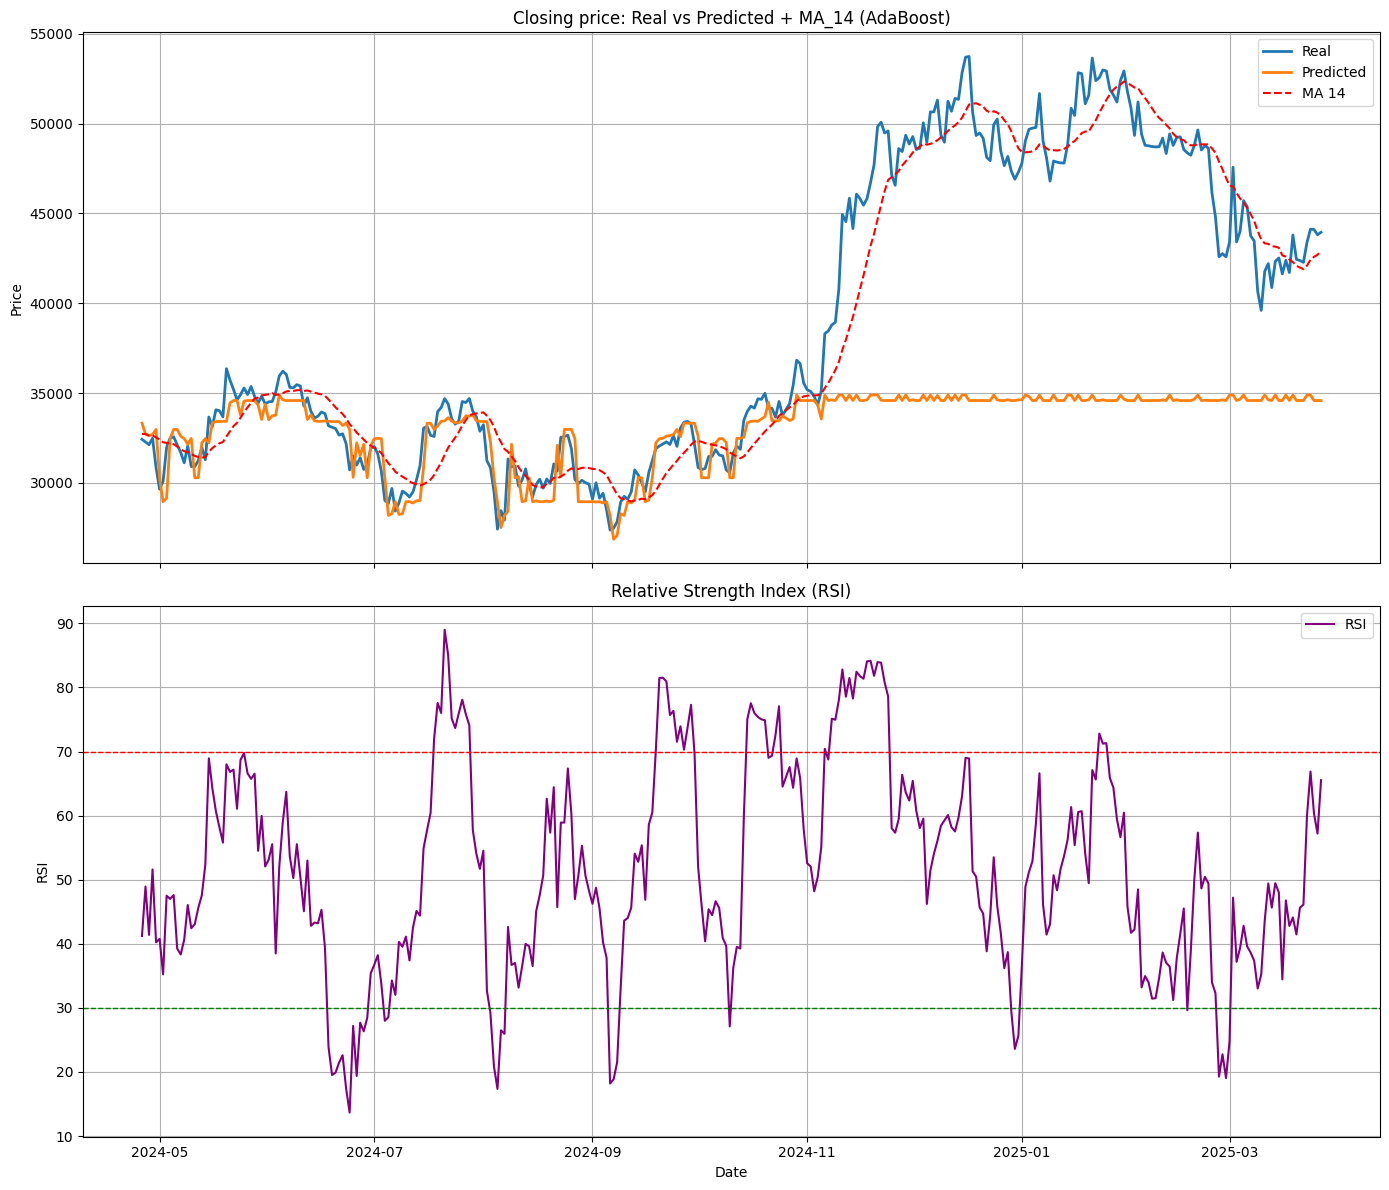

In [60]:
import matplotlib.pyplot as plt
import pandas as pd

# Garante que 'Date' está no formato datetime
df['Date'] = pd.to_datetime(df['Date'])

# Ajustar datas para o teste
dates_test = df['Date'].iloc[-len(y_test):]

fig, axs = plt.subplots(2, 1, figsize=(14, 12), sharex=True)

# 1. Preço Real vs Previsto + MA_14
axs[0].plot(dates_test, y_test.values, label="Real", linewidth=2)
axs[0].plot(dates_test, y_pred, label="Predicted", linewidth=2)
axs[0].plot(dates_test, df["MA_14"].values[-len(y_test):], label="MA 14", color="red", linestyle="--")
axs[0].set_title("Closing price: Real vs Predicted + MA_14 (AdaBoost)")
axs[0].set_ylabel("Price")
axs[0].legend()
axs[0].grid(True)

# 2. RSI
axs[1].plot(dates_test, df["RSI"].values[-len(y_test):], label="RSI", color="purple")
axs[1].axhline(70, color="red", linestyle="--", linewidth=1)
axs[1].axhline(30, color="green", linestyle="--", linewidth=1)
axs[1].set_title("Relative Strength Index (RSI)")
axs[1].set_ylabel("RSI")
axs[1].set_xlabel("Date")
axs[1].legend()
axs[1].grid(True)

plt.tight_layout()
plt.show()

# XGBoost

MSE XGBoost: 65245045.250687286


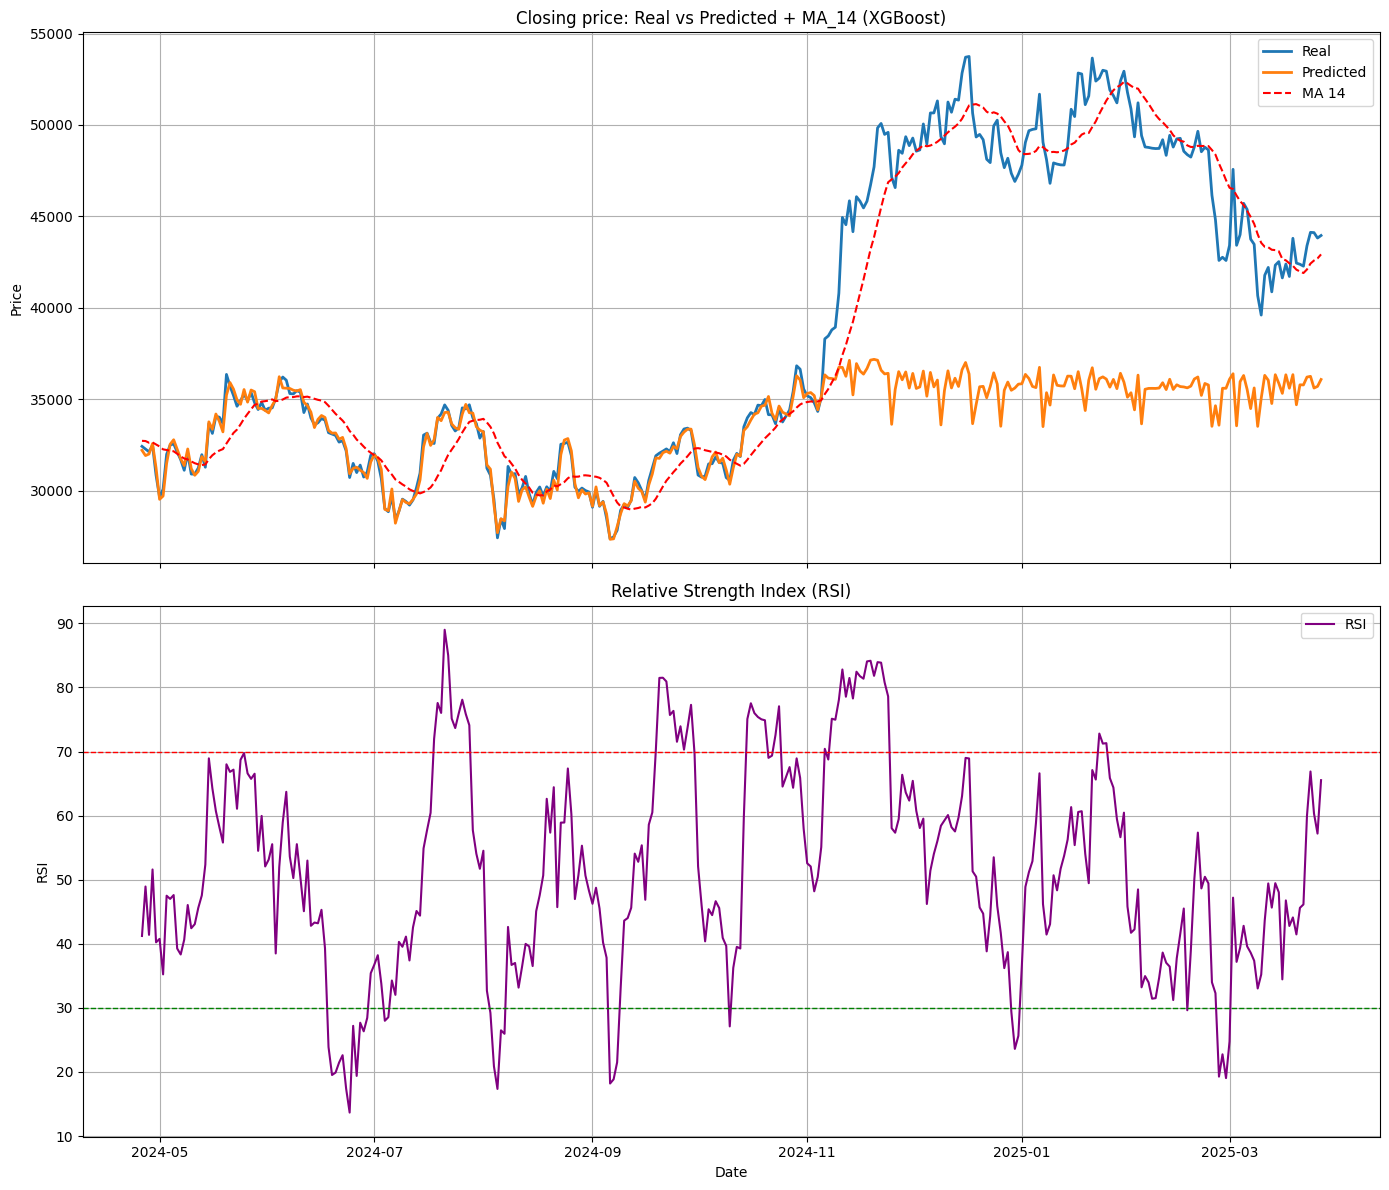

In [61]:

# Modelo XGBoost
model = XGBRegressor(n_estimators=500, learning_rate=0.05, random_state=42)
model.fit(X_train_scaled, y_train)

# Previsões
y_pred = model.predict(X_test_scaled)

# Avaliação
mse = mean_squared_error(y_test, y_pred)
print("MSE XGBoost:", mse)

# Visualização com Datas
dates_test = df['Date'].iloc[-len(y_test):]

fig, axs = plt.subplots(2, 1, figsize=(14, 12), sharex=True)

# 1. Preço Real vs Previsto + MA_14
axs[0].plot(dates_test, y_test.values, label="Real", linewidth=2)
axs[0].plot(dates_test, y_pred, label="Predicted", linewidth=2)
axs[0].plot(dates_test, df["MA_14"].values[-len(y_test):], label="MA 14", color="red", linestyle="--")
axs[0].set_title("Closing price: Real vs Predicted + MA_14 (XGBoost)")
axs[0].set_ylabel("Price")
axs[0].legend()
axs[0].grid(True)

# 2. RSI
axs[1].plot(dates_test, df["RSI"].values[-len(y_test):], label="RSI", color="purple")
axs[1].axhline(70, color="red", linestyle="--", linewidth=1)
axs[1].axhline(30, color="green", linestyle="--", linewidth=1)
axs[1].set_title("Relative Strength Index (RSI)")
axs[1].set_ylabel("RSI")
axs[1].set_xlabel("Date")
axs[1].legend()
axs[1].grid(True)

plt.tight_layout()
plt.show()


# LightGBM Regressor

In [62]:
from sklearn.ensemble import LGBMRegressor

# Modelo LightGBM
lgbm_model = LGBMRegressor(
    n_estimators=1000,
    learning_rate=0.01,
    max_depth=7,
    num_leaves=31,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_alpha=0.1,
    reg_lambda=0.1,
    random_state=42
)

# Treinamento
lgbm_model.fit(
    X_train_scaled, 
    y_train,
    eval_set=[(X_test_scaled, y_test)],
    eval_metric='mse',
)

# Previsões
y_pred = lgbm_model.predict(X_test_scaled)

# Avaliação
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"MSE LightGBM: {mse:.4f}")
print(f"RMSE LightGBM: {rmse:.4f}")
print(f"MAE LightGBM: {mae:.4f}")
print(f"R² LightGBM: {r2:.4f}")

# Visualização com Datas
dates_test = df['Date'].iloc[-len(y_test):]

# Plot
fig, axs = plt.subplots(3, 1, figsize=(14, 16), gridspec_kw={'height_ratios': [3, 1, 1]})

# 1. Preço Real vs Previsto + MA_14
axs[0].plot(dates_test, y_test.values, label="Real", linewidth=2)
axs[0].plot(dates_test, y_pred, label="Predicted", linewidth=2)
axs[0].plot(dates_test, df["MA_14"].values[-len(y_test):], label="MA 14", color="red", linestyle="--")
axs[0].set_title("Closing price: Real vs Predicted + MA_14 (LightGBM)")
axs[0].set_ylabel("Price")
axs[0].legend()
axs[0].grid(True)
axs[0].xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
axs[0].xaxis.set_major_locator(mdates.WeekdayLocator(interval=2))

# 2. RSI
axs[1].plot(dates_test, df["RSI"].values[-len(y_test):], label="RSI", color="purple")
axs[1].axhline(70, color="red", linestyle="--", linewidth=1)
axs[1].axhline(30, color="green", linestyle="--", linewidth=1)
axs[1].set_title("Relative Strength Index (RSI)")
axs[1].set_ylabel("RSI")
axs[1].legend()
axs[1].grid(True)
axs[1].set_ylim(0, 100)

# 3. Erro de previsão
error = y_test.values - y_pred
axs[2].plot(dates_test, error, label="Prediction Error", color="orange")
axs[2].axhline(0, color="black", linestyle="-", linewidth=1)
axs[2].fill_between(dates_test, error, 0, where=(error > 0), color='green', alpha=0.3)
axs[2].fill_between(dates_test, error, 0, where=(error < 0), color='red', alpha=0.3)
axs[2].set_title("Prediction Error")
axs[2].set_ylabel("Error")
axs[2].set_xlabel("Date")
axs[2].legend()
axs[2].grid(True)

plt.tight_layout()
plt.show()

# Feature Importance
feature_importance = lgbm_model.feature_importances_
feature_names = features.copy()

# Ordenar por importância
sorted_idx = np.argsort(feature_importance)
plt.figure(figsize=(10, 6))
plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), [feature_names[i] for i in sorted_idx])
plt.title('LightGBM Feature Importance')
plt.tight_layout()
plt.show()

ImportError: cannot import name 'LGBMRegressor' from 'sklearn.ensemble' (/home/pexo/miniconda3/envs/ve/lib/python3.12/site-packages/sklearn/ensemble/__init__.py)

# Guardar Modelo


In [ ]:
import joblib


# Caminho para salvar o modelo
joblib.dump(model, 'model/modelo_previsao.pkl')